In [1]:
import torch
import lightning as L
from torch.utils.data import DataLoader
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping
import numpy as np
import cv2 as cv
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm.auto import tqdm
from copy import copy, deepcopy

from image import Image
from hooked_vgg import Hooked_VGG
from style_transfer_model import StyleTransferModel
from custom_trainer import CustomTrainer

torch.set_float32_matmul_precision('medium')

### TODO

- ~~Change Image constructor to accept the shape of another image~~
- ~~Add the possibility to create an Image from a Tensor (To access the image corresponding to a trained Tensor)~~
- ~~Normalize the images~~ 
- ~~Make sure the training remains in valid values for pixels~~
- ~~Log the evolution of train loss in TensorFlow~~
- ~~Display a correct progress bar during training~~
- ~~Customize the LightningModule to have facilitated access to the final image after training~~
- ~~Include EarlyStopping in CustomTrainer~~
- ~~Add the possibility to restart training from checkpoint~~
- ~~Document the StyleTransferModule~~
- ~~Adapt the loss logging when restarting from checkpoint (adapt the logging directory)~~
- ~~Handle device switching on the StyleTransferModule~~
- ~~Create a custom loss function to compute MSE on features dicts, with potentially many features in one dict~~
- ~~Create a function for Gram matrices computation~~
- ~~Create the style loss function from Gram matrices~~
- When training ends, save the final image in the checkpoint directory (if restarting from checkpoint, replace the old image)
- ~~Make the loss weights and the optimizer be arguments of the StyleTransferModel constructor~~
- ~~Add total variation loss~~
- ~~Add a start_with argument to the Model to allow starting training from content, style or noise image~~
- Use layer names instead of indices for content and style features
- Test adding PIQE of SSIM scores to the loss to improve image quality
- Optimize the hyperparameters
- Create an easy-to-use script
- Add semantic segmentation to stylize only parts of the image ?

--> Create the best Style Transfer AI and let it dominate the world

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5292736053466798..1.5438215332031249].


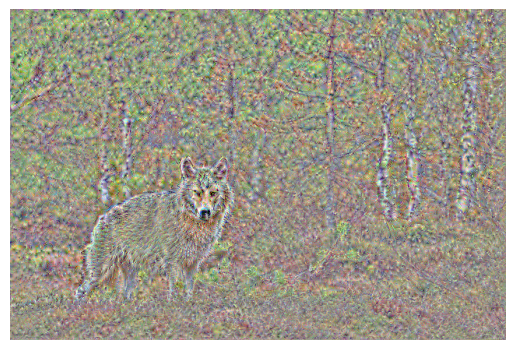

In [2]:
img_base = Image(Path('./test_images/wolf_forest.jpg'))
img_style = Image(Path('./test_images/van_gogh.jpg'))
m = StyleTransferModel(img_base, img_style)
m.train(max_epochs = 50, from_checkpoint=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
d:\Python\StyleTransferAI\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory D:\StyleTransferAI\StyleTransferAI\trainings\lightning_logs\version_146\checkpoints exists and is not empty.
Restoring states from the checkpoint path at D:\StyleTransferAI\StyleTransferAI\trainings\lightning_logs\version_146\checkpoints\epoch=49-step=50.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restored all states from the checkpoint at D:\StyleTransferAI\StyleTransferAI\trainings\lightning_logs\version_146\checkpoints\epoch=49-step=50.ckpt


Training Progress:   0%|          | 0/950 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6403674860000614..3.6644296941757206].


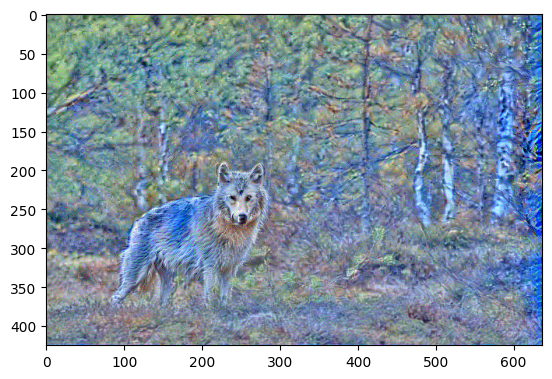

In [3]:
m.train(max_epochs=1000, from_checkpoint=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
d:\Python\StyleTransferAI\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory D:\StyleTransferAI\StyleTransferAI\trainings\lightning_logs\version_146\checkpoints exists and is not empty.
Restoring states from the checkpoint path at D:\StyleTransferAI\StyleTransferAI\trainings\lightning_logs\version_146\checkpoints\epoch=999-step=1000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restored all states from the checkpoint at D:\StyleTransferAI\StyleTransferAI\trainings\lightning_logs\version_146\checkpoints\epoch=999-step=1000.ckpt


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.889763278961182..4.059020620346069].


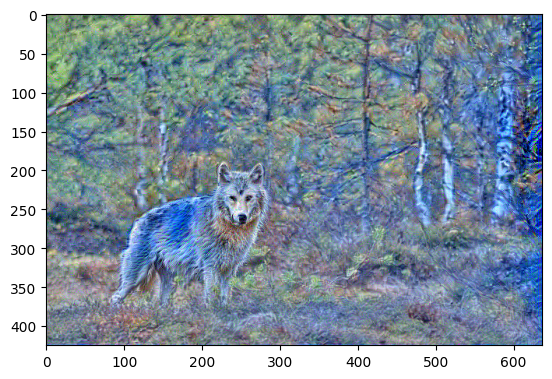

In [4]:
m.train(max_epochs=2000, from_checkpoint=True)

In [9]:
t = m.trained_img.rgb_img
(np.count_nonzero(t<0) + np.count_nonzero(t > 1)) / np.size(t)

0.012194416228029673

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.889763278961182..4.059020620346069].


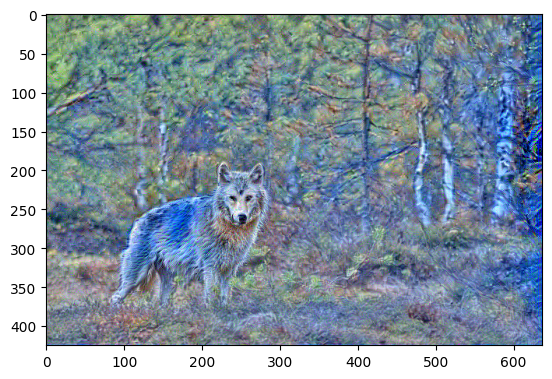

In [14]:
m.trained_img.show()

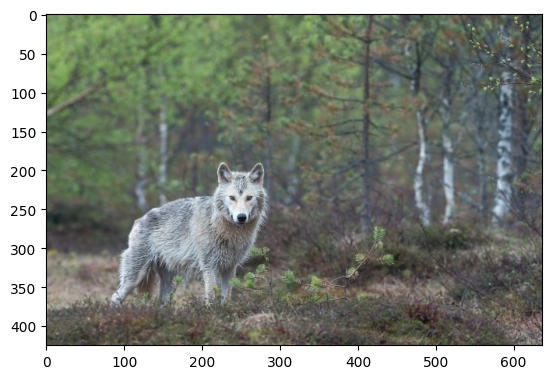

In [26]:
img_base.show()

In [2]:
img_base = Image(Path('./test_images/wolf_forest.jpg'))
img_style = Image(Path('./test_images/van_gogh.jpg'))
m = StyleTransferModel(img_base, img_style, [22], [1,6,11,20,29])
m.vgg_model.vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256